### Read and preprocess the Flow-seq data on spacer variants abundance

In [1]:
import scipy.stats as st 
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC

from base_utils import *

### Read the data on codon adaptation indices

In [2]:
codon2w = {}
with open("data/codon_w.txt") as f:
    f.readline()
    for line in f:
        s = line.strip().split()
        codon = s[0]
        w = float(s[3])
        codon2w[codon] = w
        
aa_dict = {}
li = "ATGC"
for i in range(4):
    for j in range(4):
        for k in range(4):
            codon = li[i] + li[j] + li[k]
            coding_dna = Seq(codon, IUPAC.unambiguous_dna)
            aa = str(coding_dna.translate())
            aa_dict[aa] = aa_dict.get(aa, [])
            aa_dict[aa].append(codon)

### Calculate the regression slopes (the strength of the effect) for each codon frequencies across classes

In [3]:
def get_correlation_table(class2ratios, class2ss):
    pos2codon2r = {} #pos to codon to [r,p]
    for pos in range(10):
        pos2codon2r[pos] = {}
        for codon in get_all_codons(class2ss):
            cls = []
            class_v = []
            for c in sorted(class2ratios):
                cls.append(c)
                class_v.append(class2ratios[c][pos][codon])
            r = count_corr_coef(cls, class_v)
            e = count_effect(cls, class_v, codon, pos)
            pos2codon2r[pos][codon] = r,e
    return pos2codon2r

### Show how strong is the average codon effect for each spacer position

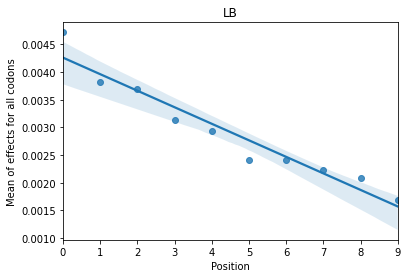

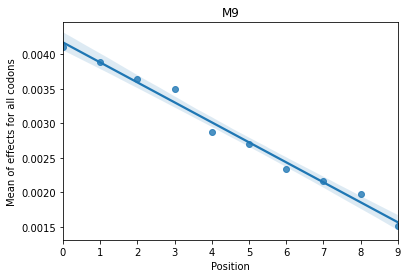

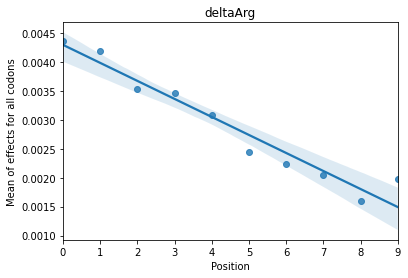

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.stats.mstats import mquantiles
import pickle
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import math

for name in ["LB", "M9", "deltaArg"]:
    fname = get_file_name(name)
    class2ss, a,b,c,d,e = import_data(fname)
    class2codons = get_real_codon_fr(class2ss)
    pos2codon2r = get_correlation_table(class2codons, class2ss)
    effects = []
    positions = list(range(10))
    ks = []
    for pos in pos2codon2r:
        effects.append([])
        k = 0
        for codon in pos2codon2r[pos]:
            r = pos2codon2r[pos][codon][0]["spearman"]
            e = pos2codon2r[pos][codon][1]
            if r > SPEARMAN_R_THRESHOLD or r < -SPEARMAN_R_THRESHOLD:
                k+=1
                effects[pos].append(e)
        ks.append(k)
    
    abs_efs = [np.mean([abs(x) for x in effects[pos]]) for pos in positions]
    positions, abs_efs = np.array(positions), np.array(abs_efs)
    sns.regplot(positions, abs_efs)
    plt.xlabel("Position")
    plt.ylabel("Mean of effects for all codons")
    plt.title(name)
    plt.show()
    plt.close()

### Check to what extent this effect could be explained solely by different nucleotide composition across classes

In [5]:
from os import listdir
from os.path import isfile, join
import pickle

mypath = "pickle/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

# in these files, you can find pre-computed values for 10000 sets of shuffled sequences

full_name2pos2codon2r = {}
for i,f in enumerate(onlyfiles):
    with open(join(mypath, f), "rb") as f:
        name2r = pickle.load(f)
        for name in name2r:
            if not name in full_name2pos2codon2r: 
                full_name2pos2codon2r[name] = name2r[name]
            else:
                for pos in sorted(full_name2pos2codon2r[name]):
                    for codon in sorted(full_name2pos2codon2r[name][pos]):
                        full_name2pos2codon2r[name][pos][codon] += name2r[name][pos][codon]

### Collect all the data about the strength of the effect and its z-score among shuffled sequences. For each codon in each position of each data sample

In [6]:
name2pos2codon2p_v = {}
name2pos2codon2z_score = {}
real_monotonous_counts = {}
for name in full_name2pos2codon2r:
    name2pos2codon2p_v[name] = {}
    name2pos2codon2z_score[name] = {}
    fname = get_file_name(name)
    class2ss, a,b,c,d,e = import_data(fname)    
    class2ratios = get_real_codon_fr(class2ss)
    pos2codon2r = get_correlation_table(class2ratios, class2ss)
    
    real_monotonous_counts[name] = []
    mon_count = 0
    for pos in sorted(full_name2pos2codon2r[name]):
        name2pos2codon2p_v[name][pos] = {}
        name2pos2codon2z_score[name][pos] = {}
        for codon in sorted(full_name2pos2codon2r[name][pos]):
            rs = pos2codon2r[pos][codon][0]
            e = pos2codon2r[pos][codon][1]
            p = get_effect_p_value(e, full_name2pos2codon2r, name, pos, codon)
            z = get_effect_z_score(e, full_name2pos2codon2r, name, pos, codon)
            
            name2pos2codon2z_score[name][pos][codon] = [z]
            if abs(rs["spearman"]) > SPEARMAN_R_THRESHOLD:   
                name2pos2codon2p_v[name][pos][codon] = [e, p, rs, ]
                mon_count += 1
            else:
                if not FLAG_USE_P_V_THRESHOLD_FOR_SIMULATED:
                    name2pos2codon2p_v[name][pos][codon] = [e, p, rs]
                else:
                    name2pos2codon2p_v[name][pos][codon] = [0.0, 0.5, rs] ########
    real_monotonous_counts[name].append(mon_count)

/home/zoe/Dropbox/rand_ramp/paper_final/base_utils.py:171: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(Z, bins = len(Z), normed = True)


### Visualize the effects for each sample

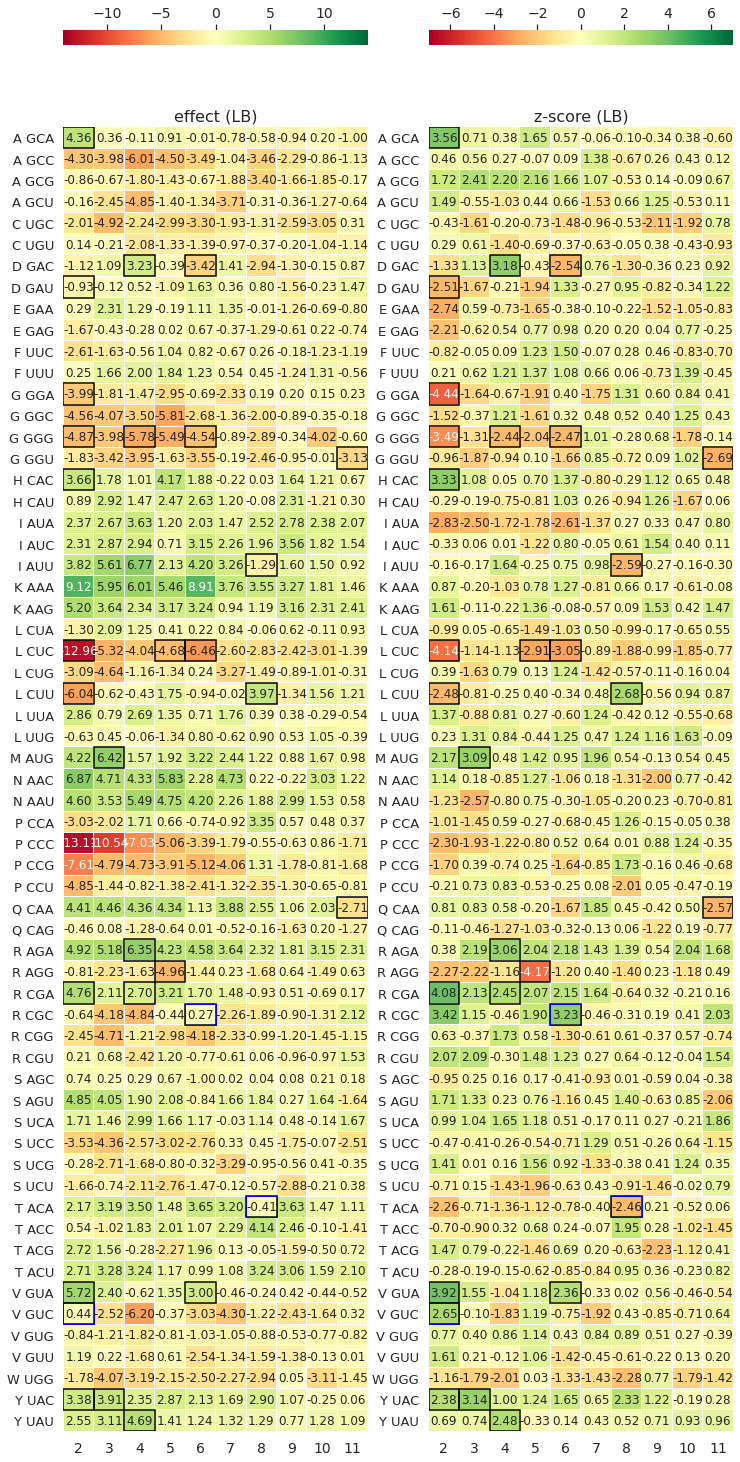

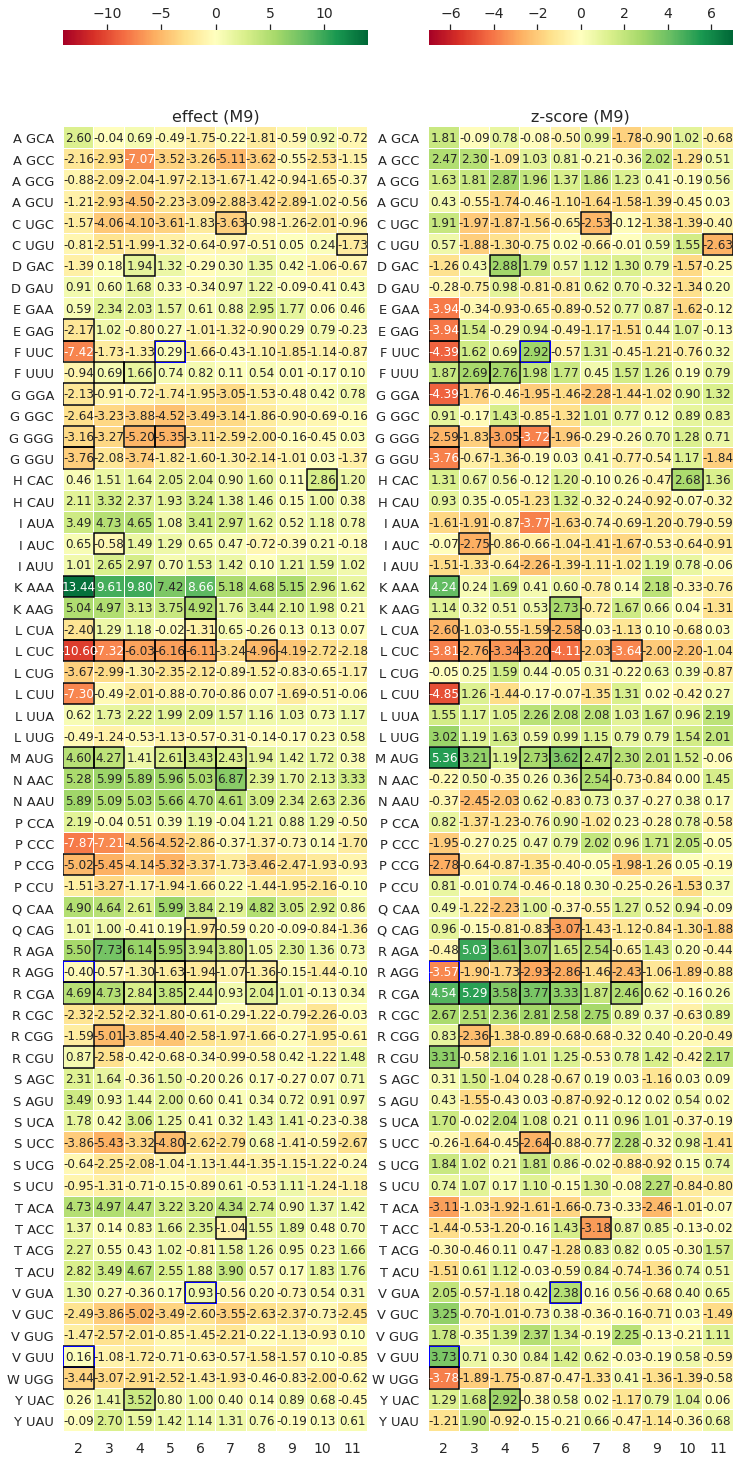

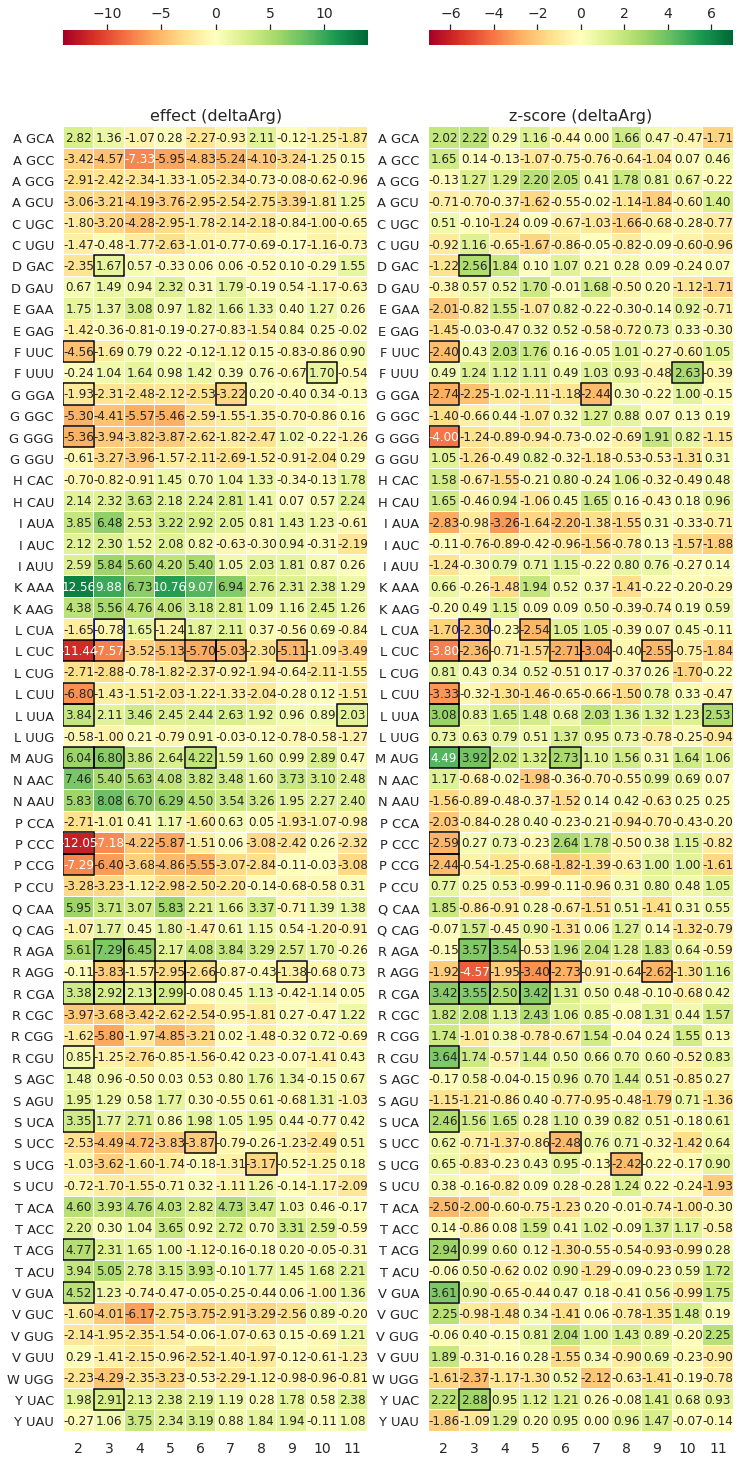

In [7]:
import matplotlib as mpl

rc={'axes.titlesize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 13}

name2df = {}   

for name in ["LB", "M9", "deltaArg"]:
    sns.set(rc=rc)
    f, ax = plt.subplots(1,2, sharey=False, figsize=(12, 30))
    pos2codon2ef = name2pos2codon2p_v[name]
    pos2codon2z = name2pos2codon2z_score[name]
    df, mask_f = reorganize_array_z(pos2codon2ef, pos2codon2z)
    codon2ef = df
    df = pd.DataFrame(data = df)
    df = df.transpose()
    df = df.sort_index()
    
    g = sns.heatmap(df, cmap="RdYlGn", annot=True, vmin=-7, vmax=7, fmt='.2f', linewidths=0.01, ax=ax[1], cbar=True, xticklabels=list(range(2,12)), cbar_kws = dict(use_gridspec=False,location="top"))
    ax[1].title.set_text("z-score (" + name + ")")
    
    add_rectangles(codon2ef, mask_f, ax, 1, pos2codon2ef)
    
    pos2codon2ef = name2pos2codon2p_v[name]
    df, mask_f = reorganize_array2(pos2codon2ef)
    codon2ef = df
    df = pd.DataFrame(data = df)
    df = df.transpose()
    df = df.sort_index()

    g = sns.heatmap(df, cmap="RdYlGn", vmin=-14, vmax=14, annot=True, fmt='.2f', linewidths=0.01, ax=ax[0], cbar=True, xticklabels=list(range(2,12)), cbar_kws = dict(use_gridspec=False,location="top"))
    ax[0].title.set_text("effect (" + name + ")")
    
    add_rectangles(codon2ef, mask_f, ax, 0, pos2codon2ef)
    
    plt.savefig(name + "_heatmaps.svg", format = "svg")
    plt.show()    

### Count the sum metabolic costs of an encoded amino acid sequence

In [8]:
aa2cost = {}
with open("data/aa_costs.txt") as f:
    for line in f:
        s = line.strip().split("\t")
        a = s[0]
        cost = float(s[1])
        aa2cost[a] = cost
        
def get_en_stats_real(aa2cost):
    genome = SeqIO.read("data/NC_000913.2.fasta", 'fasta')
    sequence = str(genome.seq).lower()                

    with open("data/cds_coord.txt") as f:
        nums = [0] * 10
        sum_en = [0] * 10
        for line in f:
            s = line.strip().split()
            begin = int(s[0])
            end = int(s[1])
            strand = s[2]
            if strand == "+":
                gene = str(genome[begin:end].seq)[3:33]
            else:
                gene = str(genome[begin:end].reverse_complement().seq)[3:33]
            if not (end-begin)%3 == 0: continue
            for i in range(10):
                p0 = i*3
                codon = gene[p0:p0+3]
                if is_stop(codon): continue
                sum_en[i] += aa2cost[get_aa_for_codon(codon)]
                nums[i] += 1
        for i in range (10):
            sum_en[i]/=nums[i]
    return sum_en

name2df = {}
for name in ["LB", "M9", "deltaArg"]:
    fname = get_file_name(name)
    class2ss, a,b,c,d,e = import_data(fname)
    class2codons = get_real_codon_fr(class2ss)
    re = get_en_stats_real(aa2cost)
    
    en_table = []
    for cl in class2codons:
        cl_tbl = []
        for pos in range(10):
            sum_en = 0
            for codon in class2codons[cl][pos]:
                fr = class2codons[cl][pos][codon]
                sum_en += fr * aa2cost[get_aa_for_codon(codon)]
            cl_tbl.append(sum_en)
        en_table.append(cl_tbl)
    en_table.append(re)
    df = pd.DataFrame(data = en_table)
    name2df[name] = df

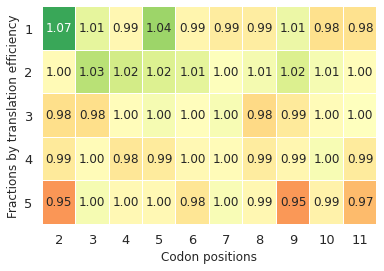

In [9]:
diff = name2df["M9"]/name2df["LB"]
g = sns.heatmap(diff[:5], cmap="RdYlGn", vmin=0.9, vmax=1.1, annot=True, fmt='.2f', linewidths=0.01, cbar=False, yticklabels=list(range(1,6)), xticklabels=list(range(2,12)))
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 13)
g.set_xticklabels(list(range(2,12)), rotation = 0, fontsize = 13)
plt.ylabel("Fractions by translation efficiency")
plt.xlabel("Codon positions")
plt.savefig("cost_diff_heatmap.svg", format="svg")
plt.show()

(-0.9023978580153185, 0.036062874236905365)


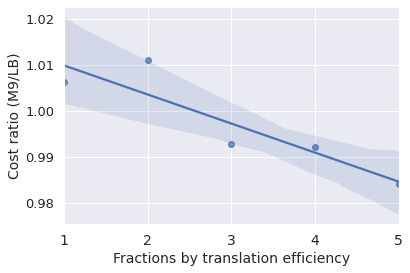

In [10]:
a = list((diff.transpose()/10).sum())
a = a[:5]
pearson = st.pearsonr(list(range(5)), a)
print(pearson)

x = np.array(list(range(1, 6)))
y = np.array(a)
g = sns.regplot(x, y)
g.set(xticks=x)

plt.xlabel("Fractions by translation efficiency", fontsize=14)
plt.ylabel("Cost ratio (M9/LB)", fontsize=14)
plt.yticks(fontsize=13)
plt.savefig("cost_diff_regplot.svg", format="svg")
plt.show()